# Ejercicio 2: "Analizando nuestro modelo" (obligatorio)

Usando como base alguno de los dos ejemplos realizar código que:
- Calcule la matriz de confusión para los dígitos. La matriz de confusión es una métrica, por lo que debe ser calculada sólo en validación.
- Utilizando la matriz de confusión elegir el par de dígitos dónde el modelo se confunde más y mostrar 20 ejemplos mal clasificados.
- Una función que muestre los 20 ejemplos de validación con mayor costo. Intuitivamente estos son los ejemplos donde el modelo está más errado: arroja probabilidades altas para clases que no son la correcta.
- Una función que muestre los 20 ejemplos de validación donde el modelo arroja probabilidades más bajas. Esto se puede interpretar como que el modelo está "poco seguro" para estos casos.

Todo este trabajo de visualización suele ser comun realizarlo cuando se trabaja con datasets reales para limpiar el dataset de ejemplos malformados, maletiquetados, etc.
En caso de utilizarlo para limpiar el dataset hay que realizarlo sobre todo el conjunto de datos (no sólo validación). Y es importante que el modelo no llegue a sobre-ajustar ni un poco (ya que usaremos por ejemplo el costo en training para limpiar el dataset).

# Solución

Para la solucion de este ejercicio se parte del ejercicio 1. 

Repetimos el codigo y sacamos notas que no son necesarias

In [123]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, random_split

import numpy as np
from matplotlib import pyplot
import math

In [124]:
# Primer prueba con el dataset original
# AUSTRAL_MCD_FACE = np.load("../data/australFace/AUSTRAL_MCD_FACE_grayscale.npy")
# AUSTRAL_MCD_FACE_target = np.load("../data/australFace/AUSTRAL_MCD_FACE_TARGET.npy")

# Segunda prueba me quedo con el top 10 de imagenes que mas se repiten
AUSTRAL_MCD_FACE = np.load("../data/australFace/AUSTRAL_MCD_FACE_top10.npy")
AUSTRAL_MCD_FACE_target = np.load("../data/australFace/AUSTRAL_MCD_FACE_TARGET_top10.npy")



In [125]:
AUSTRAL_MCD_FACE.shape, AUSTRAL_MCD_FACE_target.shape

((131, 150, 150), (131,))

In [126]:
np.unique(AUSTRAL_MCD_FACE_target, return_counts=True)

(array(['Andres', 'Carla', 'Fernanda', 'Geronimo', 'Hernan', 'Jiang',
        'Josefina', 'Mai', 'Marcelo T', 'Sebastian'], dtype='<U10'),
 array([20, 12, 14,  9, 14, 14, 11, 14, 12, 11]))

In [127]:
#Flatter de la imagen, actualmente esta en forma de matriz, quiero llevarla a un array y normalizarla.
# Supongamos que `data` tiene forma (224, 150, 150)
data_flattened = AUSTRAL_MCD_FACE.reshape(AUSTRAL_MCD_FACE.shape[0], -1)/ 255.0  # Nuevo shape será (224, 22500) + normalizacion
print(data_flattened.shape)  # Salida: (224, 22500)


(131, 22500)


Encoding del target

In [128]:
# Arreglo de nombres
names_np = AUSTRAL_MCD_FACE_target

# Crear diccionario único para codificación
unique_names = np.unique(names_np)
name_to_index = {name: i for i, name in enumerate(unique_names)}

index_to_name = {valor: clave for clave, valor in name_to_index.items()}


# Aplicar codificación
target_encoded = np.array([name_to_index[name] for name in names_np])

print("Diccionario de codificación:", name_to_index)
print("Codificación:", target_encoded)

Diccionario de codificación: {np.str_('Andres'): 0, np.str_('Carla'): 1, np.str_('Fernanda'): 2, np.str_('Geronimo'): 3, np.str_('Hernan'): 4, np.str_('Jiang'): 5, np.str_('Josefina'): 6, np.str_('Mai'): 7, np.str_('Marcelo T'): 8, np.str_('Sebastian'): 9}
Codificación: [8 0 3 8 1 9 9 1 5 6 4 0 6 8 1 5 7 6 3 5 1 3 7 7 2 4 6 7 4 2 0 8 7 2 9 0 6
 7 9 1 0 6 9 1 7 4 4 5 7 0 2 8 2 9 8 8 5 1 2 7 3 3 8 0 8 4 7 2 4 1 4 9 2 3
 6 7 2 0 1 2 2 4 4 4 8 7 0 3 9 0 3 0 8 0 5 0 5 5 2 5 2 5 6 4 1 1 0 4 6 0 7
 5 5 0 0 6 0 5 6 1 0 5 9 2 0 9 3 7 4 9 8]


In [129]:
print(f'Cantidad de caras distintas {len(np.unique(AUSTRAL_MCD_FACE_target))}')

Cantidad de caras distintas 10


Ejemplo de una imagen:

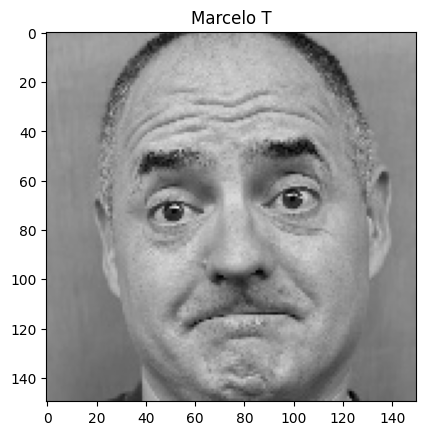

In [130]:
#data_grayscale
index = 3
pyplot.imshow(AUSTRAL_MCD_FACE[index], cmap="gray")
pyplot.title(AUSTRAL_MCD_FACE_target[index])
pyplot.show()

## Preparación del dataset

In [131]:
batch_size = 16

# Supongamos que data y target ya están en formato de tensores
data = torch.tensor(data_flattened, dtype=torch.float32)
target = torch.tensor(target_encoded, dtype=torch.long)

# Crear un conjunto de datos combinado
dataset = TensorDataset(data, target)

# Definir tamaños para train y valid
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
valid_size = len(dataset) - train_size  # 20% para validación

# Dividir los datos
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Ahora puedes crear DataLoaders si es necesario
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Tamaño de train: {len(train_dataset)}")
print(f"Tamaño de valid: {len(valid_dataset)}")


Tamaño de train: 104
Tamaño de valid: 27


Cantidad de batch creados en cada DataLoader

In [132]:
n_batches_train = len(train_dataset) // batch_size
n_batches_valid = (len(valid_dataset) + batch_size - 1) // batch_size

print(f"Batch en train: {n_batches_train}")
print(f"Batch en valid: {n_batches_valid}")

Batch en train: 6
Batch en valid: 2


## Creación de la red
### Definición de la red
Red creada para el ejercicio 1, debajo se creara una red utilizando <strong><u>nn.Modulezz</strong></u>

```python

def w_rand(n_in, n_out):
    return torch.normal(0, math.sqrt(6) / math.sqrt(n_in + n_out), size=(n_in,n_out), requires_grad=True)

W_1 = w_rand(150*150, 512)
b_1 = torch.zeros(512, requires_grad=True)

W_2 = w_rand(512, 512)
b_2 = torch.zeros(512, requires_grad=True)

W_3 = w_rand(512,25)
b_3 = torch.zeros(25, requires_grad=True)

weights = [W_1, b_1, W_2, b_2, W_3, b_3]

def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def calculate_predictions(t):
    linear_combination_1 = t @ W_1 + b_1
    hidden_layer_1 = torch.max(torch.tensor(0), linear_combination_1)
    
    linear_combination_2 = hidden_layer_1 @ W_2 + b_2
    hidden_layer_2 = torch.max(torch.tensor(0), linear_combination_2)

    linear_combination_3 = hidden_layer_2 @ W_3 + b_3
    
    return softmax(linear_combination_3)

pred = calculate_predictions(torch.tensor(data_flattened[0].flatten()))
pred, pred.shape

In [133]:
class AustralFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_1 = nn.Linear(150*150, 1024)
        self.linear_layer_2 = nn.Linear(1024, 1024)
        self.linear_layer_3 = nn.Linear(1024, 10)

    def forward(self, x):
        l1 = self.linear_layer_1(x)
        h1 = nn.ReLU()(l1)
        l2 = self.linear_layer_2(h1)
        h2 = nn.ReLU()(l2)
        l3 = self.linear_layer_3(h2)
        probs = nn.LogSoftmax(dim=-1)(l3)
        return probs

### Instanciación de la clase

In [134]:
model = AustralFace()

### Función de pérdida

Creación de la función de pérdida basada en la log-verosimilitud negativa

La función nn.NLLLoss() mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. Se utiliza generalmente en problemas de clasificación donde el modelo genera log-probabilidades como salida.

In [135]:
loss_func = nn.NLLLoss()

### Optimizador

Creacion del optimizador 

Especificamos el algoritmo de optimización <strong>Descenso de Gradiente Estocástico (SGD)</strong>. Este algoritmo ajusta los parámetros del modelo en la dirección del gradiente negativo para minimizar la función de pérdida.

In [136]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Funciones auxiliares

Creamos la funcion para medir la proporción de predicciones correctas sobre el total de predicciones realizadas.


In [137]:
def accuracy(probs, target):
    class_predictions = torch.argmax(probs, dim=1)
    return (class_predictions == target).float().mean()

## Training loop usando Pytorch:

In [138]:
n_epochs = 30

for idx_epoch in range(n_epochs):
    # Loop de entrenamiento
    loss_train_sum = 0
    n_batches_train = 0
    for x_train_batch, y_train_batch in train_loader:
        predictions = model(x_train_batch)
        loss = loss_func(predictions, y_train_batch)
        loss_train_sum += loss.item()
        n_batches_train += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluamos los datos en validación
    loss_validation_sum = 0
    accuracy_sum = 0
    for x_valid_batch, y_valid_batch in valid_loader:
        predictions = model(x_valid_batch)
        loss = loss_func(predictions, y_valid_batch)
        loss_validation_sum += loss.item()
        accuracy_sum += accuracy(predictions, y_valid_batch).item()
    
    # Imprimimos el loss en train y validación y la métrica (siempre en validación)
    accuracy_validation = accuracy_sum / n_batches_valid
    loss_validation = loss_validation_sum / n_batches_valid
    train_validation = loss_train_sum / n_batches_train
    print(f'epoch {idx_epoch} | train loss {loss_validation} | validation loss {train_validation} | accuracy {accuracy_validation}')

epoch 0 | train loss 2.3155781030654907 | validation loss 2.298998083387102 | accuracy 0.12215909361839294
epoch 1 | train loss 2.31594181060791 | validation loss 2.2916485241481235 | accuracy 0.12215909361839294
epoch 2 | train loss 2.319114089012146 | validation loss 2.2823029245649065 | accuracy 0.12215909361839294
epoch 3 | train loss 2.317867159843445 | validation loss 2.278005293437413 | accuracy 0.12215909361839294
epoch 4 | train loss 2.321887254714966 | validation loss 2.267695563180106 | accuracy 0.12215909361839294
epoch 5 | train loss 2.3257092237472534 | validation loss 2.263636486870902 | accuracy 0.12215909361839294
epoch 6 | train loss 2.324842691421509 | validation loss 2.25924927847726 | accuracy 0.12215909361839294
epoch 7 | train loss 2.323282837867737 | validation loss 2.253929308482579 | accuracy 0.12215909361839294
epoch 8 | train loss 2.325976014137268 | validation loss 2.256091458456857 | accuracy 0.12215909361839294
epoch 9 | train loss 2.3269834518432617 | va

In [ ]:
# 512 => 0.10795454680919647
# 1024 => 0.12215909361839294
# 256 => 0.10795454680919647

## Validación

In [ ]:
# Seleccionamos una imagen a evaluar

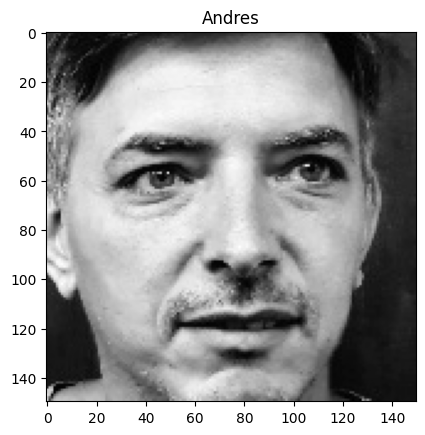

In [38]:
index = 1

pyplot.imshow(data[index].reshape(150, 150)*255.0, cmap="gray")
pyplot.title(index_to_name[target[index].item()])
pyplot.show()


In [39]:
# Ponemos el modelo en evaluacion
model.eval()

AustralFace(
  (linear_layer_1): Linear(in_features=22500, out_features=512, bias=True)
  (linear_layer_2): Linear(in_features=512, out_features=512, bias=True)
  (linear_layer_3): Linear(in_features=512, out_features=10, bias=True)
)

In [40]:

log_probs_batch = model(data[0:10])
log_probs_batch.shape

torch.Size([10, 10])

In [ ]:
#torch.exp(log_probs_batch).argmax(dim=1)
torch.exp(log_probs_batch[1])

In [ ]:
target[0:10]

In [42]:
(log_probs_batch.argmax(dim=1) == target[0:10])

tensor([False,  True, False, False, False, False, False, False, False, False])

In [41]:
accuracy(log_probs_batch, target[0:10])

tensor(0.1000)